In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import h5py
import datetime
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
%matplotlib inline

In [2]:
f_train = h5py.File("TrainEOB_q-1-10-0.02_ProperWhitenZ.h5", "r")
f_test = h5py.File("TestEOB_q-1-10-0.02_ProperWhitenZ.h5", "r")

In [3]:
f_train['WhitenedSignals']

<HDF5 dataset "WhitenedSignals": shape (9861, 8192), type "<f8">

In [4]:
np.amax(f_train['m1m2'][...])

75.15116279069767

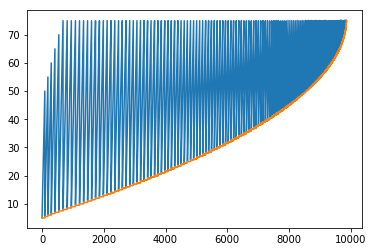

In [5]:
plt.plot(f_train['m1m2'][...].T[0])
plt.plot(f_train['m1m2'][...].T[1])

0:00:07.979806


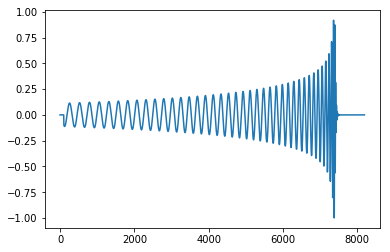

In [7]:
NUM_DATA = f_train['WhitenedSignals'].shape[0]
LENGTH = f_train['WhitenedSignals'].shape[1]
def get_batch(f,k): 
    batch = []
    label = []
    idx = np.arange(NUM_DATA)
    np.random.shuffle(idx)

    num_batch = NUM_DATA//k
    for i in range(num_batch):
        cur_batch = []
        cur_label = []
        for j in range(k):
            cur_batch.append(f['WhitenedSignals'][idx[k*i+j]])
            cur_label.append(f['m1m2'][idx[k*i+j]])
        batch.append(cur_batch)
        label.append(cur_label) 
        
    batch = np.asarray(batch).reshape(num_batch,k,LENGTH,1)
    label = np.asarray(label)
    return batch, label

def get_test(f,k):
    batch = []
    label = []
    idx = np.random.choice(f_test['WhitenedSignals'].shape[0], k, replace=False)

    for i in range(k):
        batch.append(f['WhitenedSignals'][idx[i]])
        label.append(f['m1m2'][idx[i]])

    batch = np.asarray(batch).reshape(k,LENGTH,1)
    label = np.asarray(label)
    return batch, label

start = datetime.datetime.now()
train_data, train_label = get_batch(f_train, 64)
end = datetime.datetime.now()
plt.plot(train_data[0][0])
print(end-start)

In [14]:
dilation_rates = [2**i for i in range(10)]
receptive_field = sum(dilation_rates)+2
print(receptive_field)

def WaveNet(x):
    length = tf.shape(x)[-1]
    # preprocessing causal layer
    x = tf.layers.conv1d(
        inputs=x,
        filters=16,
        kernel_size=2,
        padding="causal")
    
    skips = []

    for dilation_rate in dilation_rates:
        # filter
        x_f = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.tanh)
        
        # gate
        x_g = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.sigmoid)
        
        # element wise multiplication
        z = tf.multiply(x_f,x_g)

        # skip cut to account for receptive field
        skip = tf.slice(z, [0,receptive_field,0], [-1,-1,-1])

        # skip postprocessing
        skip = tf.layers.conv1d(
            inputs=skip,
            filters=32,
            kernel_size=1,
            padding="same")
        
        # residual postprocessing
        z = tf.layers.conv1d(
            inputs=z,
            filters=16,
            kernel_size=1,
            padding="same")
        
        # residual connection
        x = tf.add(x,z)
        
        # skip append
        skips.append(skip)
    
    # add all skip layers and apply activation
    raw = tf.add_n(skips)
    raw = tf.nn.relu(raw)

    # postprocessing
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=128,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
    
    # compress to one channel output
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=1,
            kernel_size=1,
            padding="same")

    raw = tf.layers.flatten(raw)

    # get k-highest outputs
    values, indices = tf.nn.top_k(raw, 512, False)
    #values = tf.slice(raw, [0,tf.shape(raw)[-1]-512], [-1,-1])
    values = tf.layers.dense(values, units=1024, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.25)
    values = tf.layers.dense(values, units=128, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.25)

    #indices = tf.divide(tf.cast(indices, tf.float32), tf.cast(length, tf.float32))
    #indices = tf.layers.dense(indices, units=128, activation=tf.nn.relu)
    #indices = tf.layers.dropout(inputs=indices, rate=0.2)
    
    #out = tf.multiply(tf.nn.sigmoid(indices), tf.nn.tanh(values))

    out = tf.layers.dense(values, units=2, activation=tf.nn.relu)

    return out

1025


In [29]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None, None, 1])
input_label = tf.placeholder(tf.int32, [None,2])
feedlr = tf.placeholder(tf.float32)

# loss function operations
predictions = WaveNet(input_data)
loss = tf.losses.mean_squared_error(input_label, predictions)

# train operation
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(learning_rate=0.01, 
                                           global_step=global_step, 
                                           decay_steps=NUM_DATA//64, 
                                           decay_rate=0.96, 
                                           staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=feedlr)#learning_rate)
train_op = optimizer.minimize(
    loss=loss,
    global_step=global_step)
init = tf.global_variables_initializer()

In [30]:
saver = tf.train.Saver(tf.trainable_variables())
sess = tf.Session()
sess.run(init)
loss_hist = []
val_loss = []
lrs = []
#saver.restore(sess, "../model/predictor.ckpt")

In [63]:
num_epoch = 1
start = datetime.datetime.now()
batch_size = 128
rate = 0.0001
for i in range(num_epoch):
    train_data, train_label = get_batch(f_train, batch_size)
    for j in range(len(train_data)):
        cur_data = train_data[j]
        cur_label = train_label[j]
        _, loss_val, lr = sess.run([train_op, loss, learning_rate],
                           feed_dict={input_data: cur_data,
                                      input_label: cur_label,
                                      feedlr: rate})
        loss_hist.append(loss_val)
        lrs.append(lr)
        if j % 10 == 0:
            print('loss: '+str(loss_hist[-1]))
    
    val_data, val_label = get_test(f_test, batch_size)
    validation = sess.run(loss, feed_dict={input_data: val_data, input_label: val_label})
    val_loss.append(validation)
    print('iter num: '+str(i)+' loss: '+str(loss_hist[-1])+' val_loss: '+str(val_loss[-1])+' learning_rate: '+str(lr))

end = datetime.datetime.now()
print('time: '+str(end-start))

loss: 1.5794802
loss: 1.5083728
loss: 1.2005177
loss: 2.1838837
loss: 1.9197139
loss: 1.5755339
loss: 1.4051965
loss: 1.6438408
iter num: 0 loss: 1.6104119 val_loss: 1.5366372 learning_rate: 7.456702e-05
time: 0:00:41.660283


In [88]:
test_data, test_label = get_test(f_train, batch_size)
pred = sess.run(predictions, feed_dict={input_data: test_data, input_label: test_label})
plt.figure(figsize=(15,9))
num = 0
np.mean(np.divide(abs(pred.T[num]-test_label.T[num]),test_label.T[num]))

0.03430758720925662

<Figure size 1080x648 with 0 Axes>

In [73]:
save_path = saver.save(sess, "../model/predictor.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: ../model/predictor.ckpt


Text(0.5, 1.0, 'loss and accuracy')

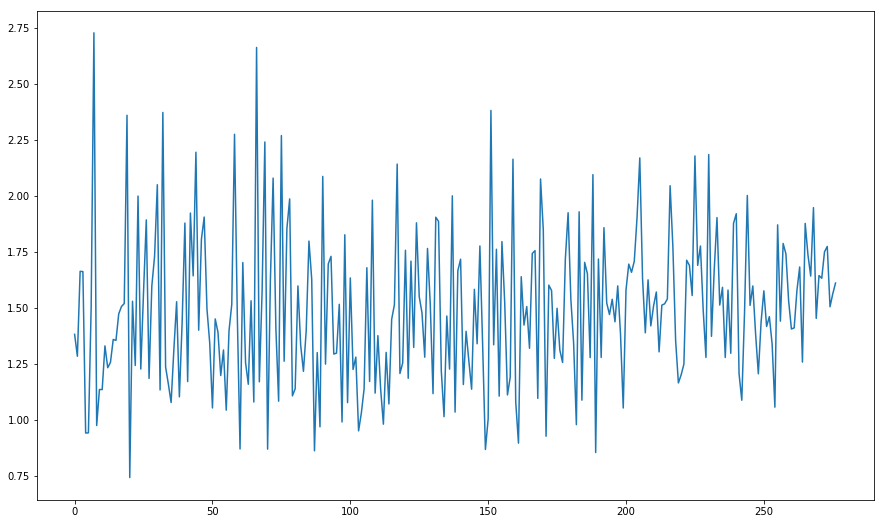

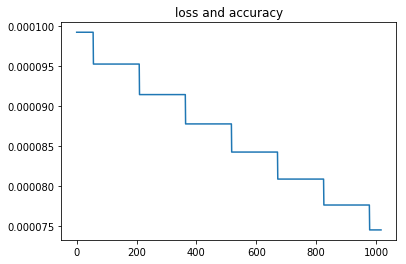

In [74]:
start = 17500
length = len(loss_hist) - start
plt.figure(figsize=(15,9))
plt.plot(loss_hist[start:],zorder=1)
#plt.scatter(np.arange(length, step=length//len(val_loss)),val_loss,c='red',zorder=2)
plt.figure()
plt.plot(lrs[start:])
plt.title('loss and accuracy')

In [53]:
tvars = tf.trainable_variables()
tvars_vals = sess.run(tvars)
for var, val in zip(tvars, tvars_vals):
    print(var.name, val) 

conv1d/kernel:0 [[[-0.04567108 -0.16597801  0.33814436  0.3586841  -0.31163472
   -0.15725043  0.3840364   0.04244948 -0.01010907  0.19291137
   -0.42233458 -0.12598787 -0.01692147 -0.11781967 -0.21595266
   -0.21058841]]

 [[-0.05982236  0.16324957 -0.17835487 -0.20097321 -0.11808781
    0.2031091  -0.28589147 -0.06323497  0.05467976  0.37312725
   -0.26249528  0.04523712  0.39443937  0.04434516  0.12051568
   -0.13501738]]]
conv1d/bias:0 [-0.01214231 -0.01222427 -0.01228174  0.01227534 -0.01223058 -0.00585324
 -0.00694981  0.00637036  0.00978385 -0.01171552 -0.01197492 -0.00931937
  0.0076441   0.01180176 -0.00749035  0.01265766]
conv1d_1/kernel:0 [[[-9.64519307e-02 -2.02735424e-01  2.09898427e-01 ... -5.58090657e-02
    6.37393817e-02 -9.46872011e-02]
  [ 2.36506145e-02 -8.45764354e-02  2.32671365e-01 ...  1.74926057e-01
    1.85800657e-01  1.38224840e-01]
  [-1.42577337e-05  2.20414549e-01 -2.64234021e-02 ...  1.45012727e-02
   -2.36505777e-01 -2.17926517e-01]
  ...
  [-5.04526719e

conv1d_24/kernel:0 [[[ 0.0915982   0.18424289  0.1789829  -0.2977626   0.20664738
    0.06847174 -0.08098961 -0.2122891  -0.10636093 -0.07998461
    0.10430741  0.03655048  0.03026195  0.00591768 -0.01291166
    0.16195565]
  [ 0.01200641  0.34308794 -0.02057551 -0.12563802  0.21991573
   -0.18830805  0.04444249 -0.26443097 -0.29160365 -0.36166862
    0.01008888 -0.24880558  0.2615324   0.18759441 -0.3387785
   -0.1615089 ]
  [-0.34701645 -0.1967479   0.2093186  -0.20219612  0.24841923
   -0.05194042 -0.2593357  -0.13750729  0.17880337  0.2819707
    0.12509659  0.03848293  0.06561635  0.2871544   0.15428309
    0.21303514]
  [ 0.33949697  0.1736781   0.052995   -0.1095602   0.3077871
    0.08575868 -0.30233973  0.17545885  0.17744645 -0.22026134
    0.04396746 -0.23716366  0.2709886  -0.09585606  0.20745099
   -0.19788782]
  [-0.09444817  0.00290606  0.28987637 -0.24586083 -0.22828475
    0.13511297 -0.12695014  0.01588729 -0.29375103  0.14881217
    0.17478955  0.00075574 -0.22590208

In [ ]:
##predictor model
dilation_rates = [2**i for i in range(10)]
receptive_field = sum(dilation_rates)+2
print(receptive_field)

def WaveNet(x):
    length = tf.shape(x)[-1]
    # preprocessing causal layer
    x = tf.layers.conv1d(
        inputs=x,
        filters=16,
        kernel_size=2,
        padding="causal")
    
    skips = []

    for dilation_rate in dilation_rates:
        # filter
        x_f = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.tanh)
        
        # gate
        x_g = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.sigmoid)
        
        # element wise multiplication
        z = tf.multiply(x_f,x_g)

        # skip cut to account for receptive field
        skip = tf.slice(z, [0,receptive_field,0], [-1,-1,-1])

        # skip postprocessing
        skip = tf.layers.conv1d(
            inputs=skip,
            filters=32,
            kernel_size=1,
            padding="same")
        
        # residual postprocessing
        z = tf.layers.conv1d(
            inputs=z,
            filters=16,
            kernel_size=1,
            padding="same")
        
        # residual connection
        x = tf.add(x,z)
        
        # skip append
        skips.append(skip)
    
    # add all skip layers and apply activation
    raw = tf.add_n(skips)
    raw = tf.nn.relu(raw)

    # postprocessing
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=128,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
    
    # compress to one channel output
    raw = tf.layers.conv1d(
            inputs=raw,
            filters=1,
            kernel_size=1,
            padding="same")

    raw = tf.layers.flatten(raw)

    # get k-highest outputs
    values, indices = tf.nn.top_k(raw, 512, False)
    #values = tf.slice(raw, [0,tf.shape(raw)[-1]-512], [-1,-1])
    values = tf.layers.dense(values, units=1024, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.25)
    values = tf.layers.dense(values, units=128, activation=tf.nn.relu)
    values = tf.layers.dropout(inputs=values, rate=0.25)

    #indices = tf.divide(tf.cast(indices, tf.float32), tf.cast(length, tf.float32))
    #indices = tf.layers.dense(indices, units=128, activation=tf.nn.relu)
    #indices = tf.layers.dropout(inputs=indices, rate=0.2)
    
    #out = tf.multiply(tf.nn.sigmoid(indices), tf.nn.tanh(values))

    out = tf.layers.dense(values, units=2, activation=tf.nn.relu)

    return out

tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None, None, 1])
input_label = tf.placeholder(tf.int32, [None,2])
feedlr = tf.placeholder(tf.float32)

# loss function operations
predictions = WaveNet(input_data)
loss = tf.losses.mean_squared_error(input_label, predictions)

# train operation
global_step = tf.Variable(0, trainable=False)

optimizer = tf.train.AdamOptimizer(learning_rate=feedlr)
train_op = optimizer.minimize(
    loss=loss,
    global_step=global_step)
init = tf.global_variables_initializer()